In [11]:
import pandas as pd
import numpy as np
import math
import time

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

In [12]:
df = bot_accounts = pd.concat(
    [
        pd.read_csv('../data/set-1/social_spambots_1.csv'),
        pd.read_csv('../data/set-1/social_spambots_2.csv'),
        pd.read_csv('../data/set-1/social_spambots_3.csv'),
        pd.read_csv('../data/set-1/geniune_accounts.csv')
    ]
).reset_index(drop=True)
df.shape

(8386, 42)

In [28]:
def feature_engineering(df):
    used_columns = [
        'statuses_count',
        'followers_count',
        'friends_count',
        'favourites_count',
        'listed_count',
        'geo_enabled',
        'profile_use_background_image',
        'default_profile',
        'default_profile_image',
        'profile_banner_url',
        'profile_text_color',
        'profile_sidebar_border_color',
        'profile_background_tile',
        'profile_sidebar_fill_color',
        'profile_background_color',
        'profile_link_color'
    ]
    df_return = df[used_columns]
    
    df_int = df_return.select_dtypes('int64')
    df_float = df_return.select_dtypes('float64')
    df_other = df_return.select_dtypes('object')
    
    df_float = 1 - df_float.isna()
    df_profile_banner_url = 1 - df_other['profile_banner_url'].isna()
    df_other = df_other.drop('profile_banner_url', axis=1)
    for i in df_other.columns:
        df_other[i] = df_other[i].apply(lambda x: int(x, 16) if isinstance(x, str) else 0)
    return pd.concat([df_int, df_float, df_profile_banner_url, df_other], axis=1)

In [29]:
df_new = feature_engineering(df)
df_new

,statuses_count,followers_count,friends_count,favourites_count,listed_count,geo_enabled,profile_use_background_image,default_profile,default_profile_image,profile_background_tile,profile_banner_url,profile_text_color,profile_sidebar_border_color,profile_sidebar_fill_color,profile_background_color,profile_link_color
0,1299,22,40,1,0,1,1,1,1,0,0,3355443,12639981,14544630,12639981,33972
1,18665,12561,3442,16358,110,1,1,0,0,1,1,3355443,16777215,15987699,15461355,10027008
2,22987,600,755,14,6,0,1,0,0,1,1,3355443,16777215,15724527,1250582,39321
3,7975,398,350,11,2,0,1,0,0,1,1,4080661,8559966,9160466,15074692,4966668
4,20218,413,405,162,8,1,1,0,0,0,1,14054213,1459997,14676207,15461355,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8381,315,94,597,36,4,1,1,0,0,0,1,3355443,16777215,15724527,1250582,39321
8382,4099,5378,1238,471,6,1,1,0,0,0,1,0,0,0,4886844,230723
8383,199,18,136,6,0,0,1,1,0,0,1,3355443,12639981,14544630,12639981,33972
8384,2609,41,263,121,0,0,1,0,0,1,1,16711680,16777215,8045550,6565259,4004183


In [21]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8386 entries, 0 to 8385
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   statuses_count                8386 non-null   int64
 1   followers_count               8386 non-null   int64
 2   friends_count                 8386 non-null   int64
 3   favourites_count              8386 non-null   int64
 4   listed_count                  8386 non-null   int64
 5   geo_enabled                   8386 non-null   int64
 6   profile_use_background_image  8386 non-null   int64
 7   default_profile               8386 non-null   int64
 8   default_profile_image         8386 non-null   int64
 9   profile_text_color            8386 non-null   int64
 10  profile_sidebar_border_color  8386 non-null   int64
 11  profile_background_tile       8386 non-null   int64
 12  profile_sidebar_fill_color    8386 non-null   int64
 13  profile_background_color      838

In [25]:
df_new.apply(lambda x: x.unique())

statuses_count                  [1299, 18665, 22987, 7975, 20218, 15259, 9551,...
followers_count                 [22, 12561, 600, 398, 413, 134, 337, 28, 2617,...
friends_count                   [40, 3442, 755, 350, 405, 401, 630, 105, 52, 2...
favourites_count                [1, 16358, 14, 11, 162, 55, 655, 38, 0, 3, 874...
listed_count                    [0, 110, 6, 2, 8, 1, 28, 3, 5, 7, 11, 9, 66, 8...
geo_enabled                                                                   [0]
profile_use_background_image                                                  [0]
default_profile                                                               [0]
default_profile_image                                                         [0]
profile_text_color              [3355443, 4080661, 14054213, 3946816, 3548960,...
profile_sidebar_border_color    [12639981, 16777215, 8559966, 1459997, 8823974...
profile_background_tile                                                       [0]
profile_sidebar_

In [26]:
df.apply(lambda x: x.unique())

id                                    [24858289, 33212890, 39773427, 57007623, 63258...
name                                  [Davide Bertoli, Elisa D'Ospina, Donato Vincen...
screen_name                           [davideb66, ElisaDospina, Vladimir65, RafielaM...
statuses_count                        [1299, 18665, 22987, 7975, 20218, 15259, 9551,...
followers_count                       [22, 12561, 600, 398, 413, 134, 337, 28, 2617,...
friends_count                         [40, 3442, 755, 350, 405, 401, 630, 105, 52, 2...
favourites_count                      [1, 16358, 14, 11, 162, 55, 655, 38, 0, 3, 874...
listed_count                          [0, 110, 6, 2, 8, 1, 28, 3, 5, 7, 11, 9, 66, 8...
url                                   [nan, http://t.co/ceK8TovxwI, http://t.co/PK5F...
lang                                  [it, en, de, ja, ru, nl, en-gb, pt, es, sv, fr...
time_zone                             [Rome, Greenland, Pacific Time (US & Canada), ...
location                        

C:\Users\Administrator\anaconda3\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Administrator\anaconda3\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Administrator\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2007: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


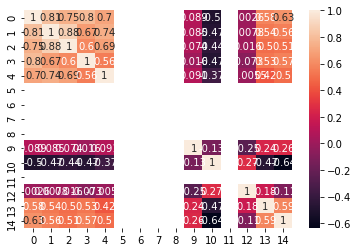

In [22]:
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(spearmanr(df_new).correlation, annot=True)
plt.show()

In [75]:
df_float.apply(lambda x: x.unique())

,geo_enabled,profile_use_background_image,default_profile,default_profile_image,profile_background_tile
0,1.0,1.0,1.0,1.0,NaN
1,NaN,NaN,NaN,NaN,1.0


In [65]:
df_float = df_float.fillna(0.0)
df_float.apply(lambda x: x.unique())

,geo_enabled,profile_use_background_image,default_profile,default_profile_image,profile_background_tile
0,1.0,1.0,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0


In [66]:
df_object.apply(lambda x: x.unique())

profile_banner_url              [nan, https://pbs.twimg.com/profile_banners/33...
profile_text_color              [333333, 3E4415, D67345, 3C3940, 362720, 3D195...
profile_sidebar_border_color    [C0DEED, FFFFFF, 829D5E, 16471D, 86A4A6, 5ED4D...
profile_sidebar_fill_color      [DDEEF6, F3F3F3, EFEFEF, 8BC712, DFF0EF, A0C5C...
profile_background_color        [C0DEED, EBEBEB, 131516, E60584, 709397, 0099B...
profile_link_color              [0084B4, 990000, 009999, 4BC90C, 000000, FF330...
dtype: object

In [67]:
df_object['profile_banner_url'] = df_object['profile_banner_url'].isna().astype('int')
df_object

<ipython-input-67-f39dc4c5de4a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_object['profile_banner_url'] = df_object['profile_banner_url'].isna().astype('int')


,profile_banner_url,profile_text_color,profile_sidebar_border_color,profile_sidebar_fill_color,profile_background_color,profile_link_color
0,1,333333,C0DEED,DDEEF6,C0DEED,0084B4
1,0,333333,FFFFFF,F3F3F3,EBEBEB,990000
2,0,333333,FFFFFF,EFEFEF,131516,009999
3,0,3E4415,829D5E,8BC712,E60584,4BC90C
4,0,D67345,16471D,DFF0EF,EBEBEB,000000
...,...,...,...,...,...,...
8381,0,333333,FFFFFF,EFEFEF,131516,009999
8382,0,000000,000000,000000,4A913C,038543
8383,0,333333,C0DEED,DDEEF6,C0DEED,0084B4
8384,0,FF0000,FFFFFF,7AC3EE,642D8B,3D1957


In [69]:
df_object = pd.get_dummies(df_object)
df_object

,profile_banner_url,profile_text_color_000000,profile_text_color_000428,profile_text_color_004358,profile_text_color_005FB3,profile_text_color_00679E,profile_text_color_0076A9,profile_text_color_0084B4,profile_text_color_0085A3,profile_text_color_0094D9,...,profile_link_color_FF6600,profile_link_color_FF6699,profile_link_color_FF6B6B,profile_link_color_FF6F00,profile_link_color_FF7A8A,profile_link_color_FF8C4C,profile_link_color_FF9500,profile_link_color_FFAE00,profile_link_color_FFCC4D,profile_link_color_FFCFCF
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8382,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8383,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8384,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
df_object['profile_banner_url']

0       False
1       False
2       False
3       False
4       False
        ...  
8381    False
8382    False
8383    False
8384    False
8385    False
Name: profile_banner_url, Length: 8386, dtype: bool

In [14]:
df_int = df_bot_temp.select_dtypes('int64')
df_float = df_bot_temp.select_dtypes('float64')
df_object = df_bot_temp.select_dtypes('object')
assert df_int.shape[1] + df_float.shape[1] + df_object.shape[1] == df_bot_temp.shape[1]

In [19]:
df_object_new = pd.get_dummies(df_object['profile_banner_url']).sum(axis=1).unique()
df_object_new

array([0, 1], dtype=int64)